
## I. VAE

#### Q1:

We sample an image by following the process of **ancestral sampling**, meaning that we sample by following the dependencies defined by our model. The process is as follows:

1. **Sample the latent variable $z_n$:**

   $$
   z_n \sim \mathcal{N}(0, \mathbf{I}_d)
   $$

   where $\mathbf{I}_d$ is the identity matrix.

2. **Compute the output of the decoder:**

   $$
   f_\theta(z_n)
   $$

   where $f_\theta$ is the decoder network parameterized by $\theta$.

3. **Sample the pixels of the image:**

   $$
   x_m \sim \mathcal{B}(f_\theta(z_n)_m)
   $$

   where $\mathcal{B}$ represents a Bernoulli distribution, and $f_\theta(z_n)_m$ gives the probability of each pixel $m$.

---

#### **Note**:
In step 3, **all pixels can be sampled in parallel**, as the pixels are independent by definition in our model.


#### Q2:

This method is inefficient because evaluating $p(x_n \mid z_n)$ is costly, and the cost increases as the dimension grows. Specifically:

- Evaluating $p(x_n \mid z_n)$ requires $M$ multiplications and $M$ sampling operations.

Additionally, this method can lead to **numerical underflows** due to the high number of multiplications of numbers between 0 and 1.


### **Q3: KL Divergence Analysis**

1. **Positivity of KL Divergence**:
   Using **Jensen's inequality**, we can see that the KL divergence is always positive:
   $$
   D_{\text{KL}}(p \| q) \geq 0
   $$

2. **Equality Case**:
   For a very small divergence, we have $p \approx q$.

3. **Infinite Divergence**:
   To get an infinite KL divergence, take $q$ such that the support of $p$ does not entirely cover the support of $q$.

   - For **Gaussian distributions**, this is not possible because both $p$ and $q$ have support over $\mathbb{R}$. 
   - However, we can approximate this behavior by choosing $p$ and $q$ such that:
     - $\mu_p$ and $\mu_q$ (the means) are far apart, i.e., $|\mu_p - \mu_q|$ is large.
     - $\sigma_p$ and $\sigma_q$ (the standard deviations) are small.

   This results in two spikes that barely overlap, leading to a very large divergence.


#### Q4: Rewriting $ \log p(x_n) $

The marginal likelihood $ \log p(x_n) $ can be expressed as:

$$
\log p(x_n) = \log \int p(x_n, z_n) \, dz_n
$$

Directly computing this is challenging because of the integral over the latent variable $ z_n $.


#### Q5: Pushing up the ELBO

When pushing up the ELBO 2 behaviors can arise:

- $ \log p(x_n) $ can increase. In that case, our model assigns higher probability to the observed data. This directly improves the quality of the generated images.

- $ KL(q(Z|x_n) \| p(Z|x_n)) $ can decrease. In that case, we are learning a better encoder since the probability distribution learned is closer to reality.

At any rate, optimizing the lower bound (ELBO) improves the model by either increasing the likelihood of the data or aligning the encoder's distribution with the true posterior, ultimately yielding better image generation.




#### Q6:



#### Q9:

**Encoder**:

    self.fc1 = nn.Linear(input_dim, 400)
    self.fc_mu = nn.Linear(400, latent_dim)  # Mean of q(z|x)
    self.fc_logvar = nn.Linear(400, latent_dim)  # Log-variance of q(z|x)

**Decoder**:

    self.fc1 = nn.Linear(latent_dim, 400)
    self.fc2 = nn.Linear(400, output_dim)

**Hyperparameters**:

    batch_size = 128
    learning_rate = 1e-3
    epochs = 20
    latent_dim = 20
    input_dim = 28 * 28



#### Q10:

From left to right, output with no training, 10 epochs and 80 epochs.

The images produced look realistic but are far from perfect and quite blurry. Also, the quality doesn't improve going from 10 to 80 epochs, even when trying to adjust the hyperparameters, especially reducing the lr.

Nonetheless ,the diversity of the images is good with classes that are almost evenly distributed.

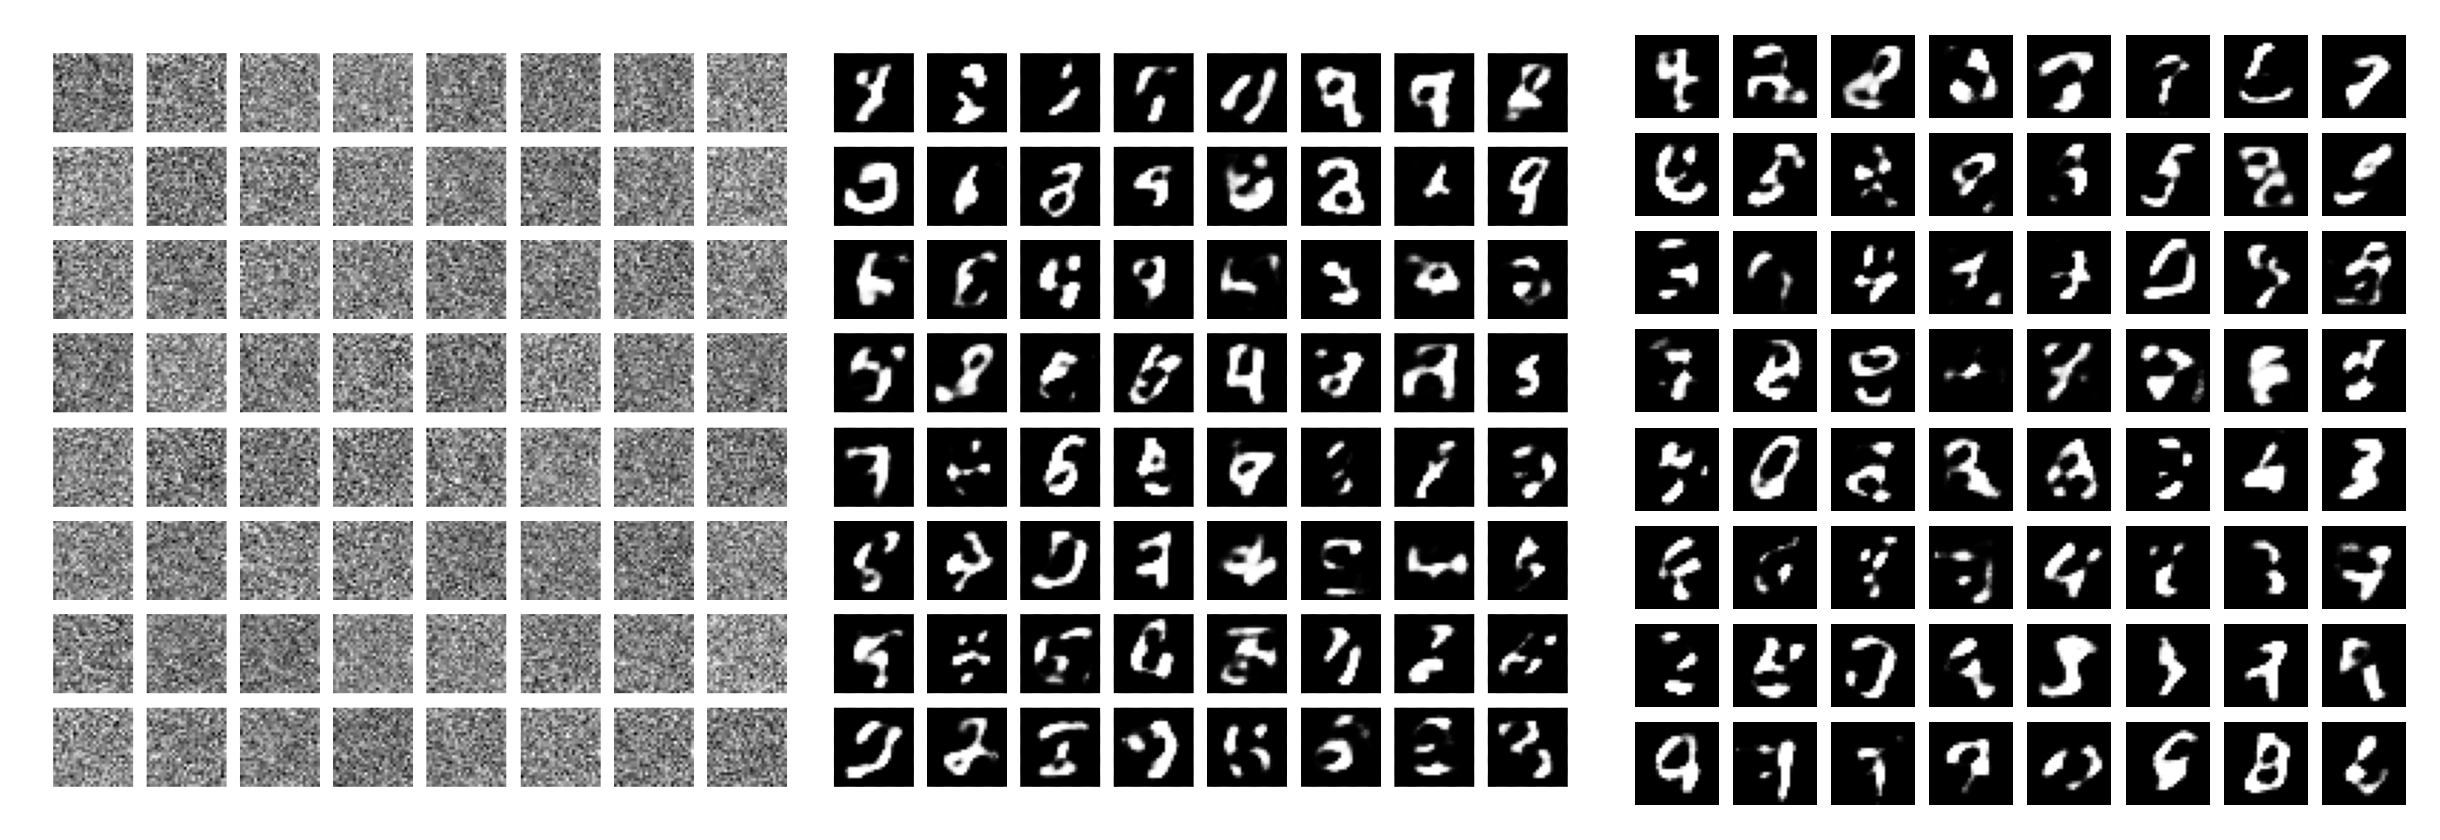

## II. Diffusion models

#### Q11:

Using the definition of the marginal likelihood:

$$
\log p(x) = \log \int p(x, z_{1:T}) \, dz_{1:T},
$$

we introduce the variational distribution $q_\phi(z_{1:T} | x)$ to make the integral more tractable. By multiplying and dividing by $q_\phi(z_{1:T} | x)$, we get:

$$
\log p(x) = \log \int q_\phi(z_{1:T} | x) \frac{p(x, z_{1:T})}{q_\phi(z_{1:T} | x)} \, dz_{1:T}.
$$

Applying Jensen's inequality, we obtain:

$$
\log p(x) \geq \int q_\phi(z_{1:T} | x) \log \frac{p(x, z_{1:T})}{q_\phi(z_{1:T} | x)} \, dz_{1:T}.
$$

Simplifying the right-hand side, this becomes:

$$
\log p(x) \geq \mathbb{E}_{q_\phi(z_{1:T} | x)} \left[ \log p(x, z_{1:T}) - \log q_\phi(z_{1:T} | x) \right].
$$

Thus, the **Evidence Lower Bound (ELBO)** for the Markovian Hierarchical Variational Autoencoder is:

$$
\log p(x) \geq \mathbb{E}_{q_\phi(z_{1:T} | x)} \left[ \log \frac{p(x, z_{1:T})}{q_\phi(z_{1:T} | x)} \right].
$$


#### Q12:

The overall architecture of the model consists in an encoder-decoder architecture where in each step of the encoding phase some noise is added to the previous image.
The observed data point 
$x$ is treated as the initial latent variable $z_0$ in the hierarchical framework.

1. During the forward diffusion process, the latent variable $z_t$ is produced at each timestep by applying a linear Gaussian transformation to $z_{t-1}$ , introducing noise as defined by the model

2. During the reverse (generation) process, the VDM attempts to reconstruct the original data $x$ by iteratively denoising the latent variables $z_T, z_{t-1}...$

3. At each reverse timestep, the model predicts the noise added at that step to guide the reconstruction process.

#### Q13:

- The prior matching term acts as a regularization term that disentangles the latent space, just like it was the case with standard VAEs
- The consistency teerm also acts as a regularization term and enforces that the noise added at during the encoding process is the same as the noise removed during the decoding process. It enforces consistency between the forward (encoding) and reverse (decoding) processes, improving the model's stability
- The reconstruction term plays the same role as in standard VAEs by maximizing the likelihood of the data under the model

#### Q14:

Let's prove this by induction:

#### **Inductive Hypothesis:**
Assume $z_k \sim \mathcal{N}(\sqrt{\bar{\alpha}_k} z_0, (1 - \bar{\alpha}_k) I)$, where $\bar{\alpha}_k = \prod_{i=1}^k \alpha_i$.

#### **Base Case (\( t = 1 \)):**
From the reparametrization equation:

$z_1 = \sqrt{\alpha_1} z_0 + \sqrt{1 - \alpha_1} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$
Thus, $z_1 \sim \mathcal{N}(\sqrt{\alpha_1} z_0, (1 - \alpha_1) I)$, matching Equation (26) with $\bar{\alpha}_1 = \alpha_1$.

#### **Inductive Step:**
For $t = k + 1$, from the reparametrization equation:
$$
z_{k+1} = \sqrt{\alpha_{k+1}} z_k + \sqrt{1 - \alpha_{k+1}} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I).
$$
Substituting $z_k \sim \mathcal{N}(\sqrt{\bar{\alpha}_k} z_0, (1 - \bar{\alpha}_k) I)$, we have:
$
z_{k+1} = \sqrt{\alpha_{k+1} \bar{\alpha}_k} z_0 + \sqrt{\alpha_{k+1}} \eta + \sqrt{1 - \alpha_{k+1}} \epsilon,
$
where $\eta \sim \mathcal{N}(0, (1 - \bar{\alpha}_k) I)$.

The noise terms combine as:
$
\sqrt{\alpha_{k+1}} \eta + \sqrt{1 - \alpha_{k+1}} \epsilon \sim \mathcal{N}(0, (1 - \alpha_{k+1} \bar{\alpha}_k) I).
$

Thus:
$$
z_{k+1} \sim \mathcal{N}(\sqrt{\bar{\alpha}_{k+1}} z_0, (1 - \bar{\alpha}_{k+1}) I),
$$
where $\bar{\alpha}_{k+1} = \alpha_{k+1} \bar{\alpha}_k$.

#### **Conclusion:**
By induction, $z_t \sim \mathcal{N}(\sqrt{\bar{\alpha}_t} z_0, (1 - \bar{\alpha}_t) I)$, where $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$.


#### Q15:

Injection inside $(28)$, we get:

$
\arg\min_\theta \frac{1}{2 \sigma_q^2(t)} \left\| \mu_\theta - \mu_q \right\|^2
$

$
= \arg\min_\theta \frac{1 - \bar{\alpha}_t}{(1 - \alpha_t)(1 - \bar{\alpha}_{t-1})} \cdot \frac{\bar{\alpha}_{t-1} (1 - \alpha_t)^2}{1 - \bar{\alpha}_t} \left\| z_0 - \hat{z}_\theta(z_t, t) \right\|^2
$

$
= \arg\min_\theta \frac{\bar{\alpha}_{t-1} (1 - \alpha_t)}{1 - \bar{\alpha}_{t-1}} \left\| z_0 - \hat{z}_\theta(z_t, t) \right\|^2
$

Therefore, we can see that this term enforces the reconstruction of the $t$-th latent variable to be as close as possible to the original image

#### Q16:

Generalizing the SNR formula to a multidimensional setting, we get:

$\frac{\bar{\alpha}_t \|z_0\|^2 }{\mathrm{Tr}((1 - \bar{\alpha}_t) I)}$

i.e 

$\frac{ \bar{\alpha}_t \|z_0\|^2}{D(1 - \bar{\alpha}_t)}$

where $D$ is the dimension of the image